# Multi-class classification on MNIST dataset

In [1]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import transforms as T
from torch import nn
from torchvision import models
from torch import optim

import snippet
from PyTorchTrainer.train import Phase, RollingLoss, train
from PyTorchTrainer.callback import CallbacksGroup
from PyTorchTrainer.scheduler import Scheduler, OneCycleSchedule
from PyTorchTrainer.logging import TensorBoardLogger, StreamLogger, ProgressBar
from PyTorchTrainer.metric import Accuracy

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
batch_size = 1024
n_epochs = 3
mnist_stats = ((0.15,), (0.15,))

## 1. Loading Data

In [3]:
train_ds = MNIST(
    root = './data/',
    train=True, 
    download=True,
    transform=T.Compose([
        T.RandomAffine(5, translate=(0.05, 0.05), scale=(0.9, 1.1)),
        T.ToTensor(),
        T.Normalize(*mnist_stats)
    ])
)

val_ds = MNIST(
    root = './data/',
    train=False, 
    transform=T.Compose([
        T.ToTensor(),
        T.Normalize(*mnist_stats)
    ])
)

train_dl = DataLoader(train_ds, 
                      batch_size=batch_size,
                      shuffle=True, 
                      num_workers=4)
val_dl = DataLoader(val_ds, 
                      batch_size=batch_size,
                      shuffle=True, 
                      num_workers=4)

## 2. Neural Network

In [4]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)

## 3. Training

In [5]:
model = Net()
phases = [
    Phase('train', train_dl),
    Phase('valid', val_dl, grad=False)
]
opt = optim.Adam(model.parameters(), lr=1e-2)
cb = CallbacksGroup([
  RollingLoss(),
  Accuracy(),
  Scheduler(
        OneCycleSchedule(t=len(phases[0].loader) * n_epochs),
        mode='batch'
    ),
  TensorBoardLogger('./runs/', 'test-classification'),
  StreamLogger(),
  ProgressBar()
])
loss = nn.CrossEntropyLoss()
train(model, opt, phases, cb, epochs=n_epochs, loss_fn=loss)

Epoch:    1 | train_loss=0.9404, train_accuracy=0.6204, valid_loss=0.1229, valid_accuracy=0.9641
Epoch:    2 | train_loss=0.5452, train_accuracy=0.8649, valid_loss=0.1005, valid_accuracy=0.9751
Epoch:    3 | train_loss=0.3955, train_accuracy=0.8977, valid_loss=0.0890, valid_accuracy=0.9773


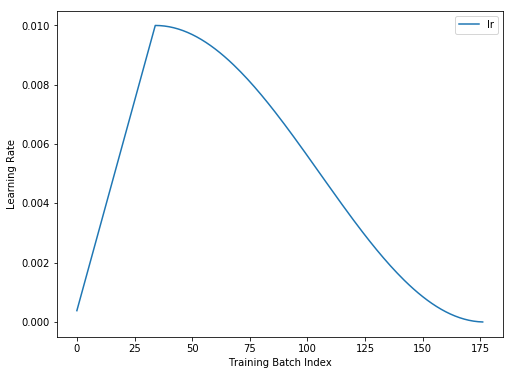

In [6]:
lr_history = pd.DataFrame(cb['scheduler'].parameter_history('lr'))
ax = lr_history.plot(figsize=(8, 6))
ax.set_xlabel('Training Batch Index')
ax.set_ylabel('Learning Rate')
plt.show()

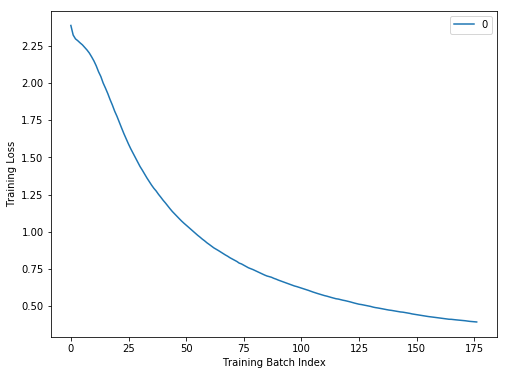

In [7]:
loss_history = pd.DataFrame(phases[0].losses)
ax = loss_history.plot(figsize=(8, 6))
ax.set_xlabel('Training Batch Index')
ax.set_ylabel('Training Loss')
plt.show()